In [39]:
import matplotlib
%matplotlib inline
import numpy as np
from helpers import get_pp_fn, make_datelist, get_radar_mask, get_config,\
                    get_domain_limits, read_netcdf_dataset
from netCDF4 import Dataset
from datetime import datetime, timedelta
from cosmo_utils.pyncdf import getfobj_ncdf_timeseries
from cosmo_utils.helpers import yyyymmddhh_strtotime
from numpy.ma import masked_array

In [42]:
# Some reproduceability information
from subprocess import check_output
print(check_output(['conda', 'info']))
print(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"))

Current conda install:

               platform : linux-64
          conda version : 4.3.14
       conda is private : False
      conda-env version : 4.3.14
    conda-build version : not installed
         python version : 2.7.13.final.0
       requests version : 2.12.4
       root environment : /home/s/S.Rasp/anaconda2  (writable)
    default environment : /home/s/S.Rasp/anaconda2/envs/py_env
       envs directories : /home/s/S.Rasp/anaconda2/envs
                          /home/s/S.Rasp/.conda/envs
          package cache : /home/s/S.Rasp/anaconda2/pkgs
                          /home/s/S.Rasp/.conda/pkgs
           channel URLs : https://repo.continuum.io/pkgs/free/linux-64
                          https://repo.continuum.io/pkgs/free/noarch
                          https://repo.continuum.io/pkgs/r/linux-64
                          https://repo.continuum.io/pkgs/r/noarch
                          https://repo.continuum.io/pkgs/pro/linux-64
                          https://repo.co

In [26]:
# Settings
from argparse import Namespace
args = Namespace(date_start = '2016052800',
                 date_end = '2016052900',
                 time_start = 1,
                 time_end = 24,
                 time_inc = 1,
                 nens = 2,
                 config_file = 'config.yml',
                 recompute = False)

In [11]:
# Step 1: Preprocessing
# Define functions
def domain_mean_weather_ts(inargs, log_str):
    """
    Calculate hourly time-series for domain mean variables:
    
    - hourly precipitation
    - CAPE
    - convective adjustment timescale
    - boundary layer height
    Precipitation is analyzed for ensemble, deterministic and observations.
    All other values are calculated for the ensemble mean and deterministic.

    Parameters
    ----------
    inargs : argparse object
      Argparse object with all input arguments
    log_str : str
      Log text for NetCDF file

    Returns
    -------

    """

    rootgroup = create_netcdf_weather_ts(inargs, log_str)

    radar_mask = get_radar_mask(inargs)
    print('Number of masked grid points: ' + str(np.sum(radar_mask)) +
          ' from total grid points: ' + str(radar_mask.size))

    # Load analysis data and store in NetCDF
    for idate, date in enumerate(make_datelist(inargs)):
        print('Computing time series for: ' + date)
        for group in rootgroup.groups:
            for ie in range(rootgroup.groups[group].dimensions['ens_no'].size):
                for var in rootgroup.groups[group].variables:

                    compute_ts_mean(inargs, idate, date, group, ie, var,
                                    rootgroup, radar_mask)

    # Close NetCDF file
    rootgroup.close()

    
def compute_ts_mean(inargs, idate, date, group, ie, var, rootgroup,
                    radar_mask):
    """
    Compute mean time series and appends it to rootgroup object.
    
    Parameters
    ----------
    inargs : argparse object
      Argparse object with all input arguments
    idate : int
      index of date
    date : str
      Date to analyze
    group : str
      Group name
    ie  : int 
      Ensemble Member
    var : str 
      COSMO variable to analyze
    rootgroup : NetCDF Dataset object
      NetCDF rootgroup
    radar_mask : np.array
      Total radar mask

    """
    if group in ['det', 'ens']:
        if group == 'det':
            ens_no = 'det'
        else:
            ens_no = ie + 1
        datalist = get_datalist_model(inargs, date, ens_no, var, radar_mask)
    elif group == 'obs':
        if not var == 'PREC_ACCUM':
            return
        datalist = get_datalist_radar(inargs, date, radar_mask)
    else:
        raise Exception('Wrong group.')

    # Compute domain mean and save in NetCDF file
    # Note: Need to loop, because array operation ignores mask
    mean_ts = []
    for data in datalist:
        mean_ts.append(np.mean(data))
    rootgroup.groups[group].variables[var][idate, :, ie] = np.array(mean_ts)

    
def get_datalist_model(inargs, date, ens_no, var, radar_mask):
    """
    Get data time series for model output.
    Parameters
    ----------
    inargs : : argparse object
      Argparse object with all input arguments
    date : str
      Date in format yyyymmddhh
    ens_no : int or str 
      Ensemble number or str in case of det
    var : str 
      Variable
    radar_mask : 2D numpy array
      Radar mask to create masked arrays

    Returns
    -------
    datalist : list
      List of 2D masked arrays
    """
    # Get file name
    ncdffn_pref = (get_config(inargs, 'paths', 'raw_data') +
                   date + '/deout_ceu_pspens/' + str(ens_no) +
                   '/OUTPUT/lfff')
    datalist = getfobj_ncdf_timeseries(ncdffn_pref,
                                       timedelta(hours=inargs.time_start),
                                       timedelta(hours=inargs.time_end),
                                       timedelta(hours=inargs.time_inc),
                                       ncdffn_sufx='.nc_30m_surf',
                                       return_arrays=True,
                                       fieldn=var)
    # Crop data
    l11, l12, l21, l22, l11_rad, l12_rad, l21_rad, l22_rad = \
        get_domain_limits(inargs)
    for i, data in enumerate(datalist):
        datalist[i] = masked_array(data[l11:l12, l21:l22],
                                   mask=radar_mask)
    return datalist


def get_datalist_radar(inargs, date, radar_mask=False):
    """
    Get data time series for radar observation.
    Parameters
    ----------
    inargs : : argparse object
      Argparse object with all input arguments
    date : str
      Date in format yyyymmddhh. If 'all', radar data for all days are returned
    radar_mask : 2D numpy array
      Radar mask to create masked arrays.

    Returns
    -------
    datalist : list
      List of 2D masked arrays
    """
    # Get file name
    radarpref = (get_config(inargs, 'paths', 'radar_data') +
                 get_config(inargs, 'paths', 'radar_prefx'))
    radarsufx = get_config(inargs, 'paths', 'radar_sufix')
    dtradar = timedelta(minutes=10)
    if date is 'all':
        date_start = (yyyymmddhh_strtotime(inargs.date_start) +
                      timedelta(hours=inargs.time_start) - dtradar)
        date_end = (yyyymmddhh_strtotime(inargs.date_end) +
                    timedelta(hours=inargs.time_end)-dtradar)
    else:
        dateobj = yyyymmddhh_strtotime(date)
        date_start = dateobj + timedelta(hours=inargs.time_start) - dtradar
        date_end = dateobj + timedelta(hours=inargs.time_end) - dtradar
    datalist = getfobj_ncdf_timeseries(radarpref,
                                       date_start,
                                       date_end,
                                       timedelta(hours=inargs.time_inc),
                                       reftime=date_start,
                                       ncdffn_sufx=radarsufx,
                                       fieldn='pr',
                                       abs_datestr='yymmddhhmm',
                                       dwdradar=True,
                                       return_arrays=True)
    # Crop data
    l11, l12, l21, l22, l11_rad, l12_rad, l21_rad, l22_rad = \
        get_domain_limits(inargs)
    if not radar_mask is False:
        # Apply total mask to data
        for i, data in enumerate(datalist):
            datalist[i] = masked_array(data[l11_rad:l12_rad,
                                            l21_rad:l22_rad],
                                       mask=radar_mask)
    return datalist


def create_netcdf_weather_ts(inargs, log_str):
    """
    Creates a NetCDF object to store weather time series data.
    
    3 groups : obs, det, ens
    3 dimensions : date, time, ens_no (1 for det and obs)
    4 variables : mean_prec, mean_cape, mean_tauc, mean_hpbl
    
    Parameters
    ----------
    inargs : argparse object
      Argparse object with all input arguments
    log_str : str
      Log text for NetCDF file

    Returns
    -------
    rootgroup : NetCDF object

    """

    pp_fn = get_pp_fn(inargs)

    # Create NetCDF file
    rootgroup = Dataset(pp_fn, 'w', format='NETCDF4')
    rootgroup.log = log_str

    groups = ['obs', 'det', 'ens']
    datearray = np.array(make_datelist(inargs, out_format='netcdf'))
    timearray = np.arange(inargs.time_start, inargs.time_end + inargs.time_inc,
                          inargs.time_inc)
    dimensions = {
        'time': timearray.size,
        'date': datearray.size,
    }
    variables = {
        'PREC_ACCUM': ['date', 'time'],
        #'CAPE_ML': ['date', 'time'],
        #'TAU_C': ['date', 'time'],
        #'HPBL': ['date', 'time'],
    }

    # Create root dimensions and variables
    for dim_name, dim_len in dimensions.items():
        rootgroup.createDimension(dim_name, dim_len)

    rootgroup.createVariable('time', 'i8', ('time'))
    rootgroup.createVariable('date', 'i8', ('date'))
    rootgroup.variables['time'][:] = timearray
    rootgroup.variables['date'][:] = datearray


    # Create group dimensions and variables
    [b.append('ens_no') for a, b in variables.items()]
    dimensions['ens_no'] = 1

    for g in groups:
        rootgroup.createGroup(g)
        if g == 'ens':
            dimensions['ens_no'] = inargs.nens

        # Create dimensions
        for dim_name, dim_len in dimensions.items():
            rootgroup.groups[g].createDimension(dim_name, dim_len)

        # Create variables
        for var_name, var_dims in variables.items():
            rootgroup.groups[g].createVariable(var_name, 'f8', var_dims)
    return rootgroup

In [36]:
# Call preprocessing function
print get_pp_fn(args)
domain_mean_weather_ts(args, 'log str')

/project/meteo/scratch/users/stephan.rasp/convective_variability_data/preproc_data/time_start-1_date_end-2016052900_date_start-2016052800_time_end-24_time_inc-1_config_file-config.yml_nens-2.nc
Found radar mask: ../aux_files/radar_tot_mask_2016052800_2016052900.npy
Number of masked grid points: 4769 from total grid points: 65536
Computing time series for: 2016052800
Computing time series for: 2016052900


In [37]:
# Step 2: Plot the data
import matplotlib.pyplot as plt
# define the functions
def plot_domain_mean_weather_ts_composite(inargs):
    """
    Function to plot time series of domain mean weather as a composite over 
    all days

    Parameters
    ----------
    inargs : argparse object
      Argparse object with all input arguments

    Returns
    -------

    """

    # Read pre-processed data
    rootgroup = read_netcdf_dataset(inargs)
    x = rootgroup.variables['time'][:]

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for group in rootgroup.groups:
        prec = rootgroup.groups[group].variables['PREC_ACCUM'][:]
        mean_prec = np.mean(prec, axis = (0,2))
        ax.plot(x, mean_prec, label=group,
               c=get_config(inargs, 'colors', group))

    ax.set_ylabel('Accumulation [mm/h]')
    ax.set_xlabel('Time [UTC]')
    dateobj_start = (timedelta(seconds=int(rootgroup.variables['date'][0])) +
                     datetime(1,1,1))
    datestr_start = dateobj_start.strftime(get_config(inargs, 'colors',
                                                      'date_fmt'))
    dateobj_end = (timedelta(seconds=int(rootgroup.variables['date'][-1])) +
                   datetime(1, 1, 1))
    datestr_end = dateobj_end.strftime(get_config(inargs, 'colors',
                                                  'date_fmt'))
    comp_str = 'Composite ' + datestr_start + ' - ' + datestr_end
    ax.set_title(comp_str)
    ax.legend(loc=0)

    plt.tight_layout()

    # Save figure
    plotfn = (get_config(inargs, 'paths', 'figures') + 'weather_ts_composite_' +
              get_pp_fn(inargs, sufx='.pdf', pure_fn=True))
    fig.savefig(plotfn)


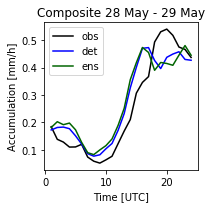

In [40]:
plot_domain_mean_weather_ts_composite(args)